In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()

Paths defined in paths module:
 paths.data_root: /Users/trafferty/data
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.images_root: /Users/trafferty/data/images
 paths.projects_root: /Users/trafferty/data/projects
 paths.results_root: /Users/trafferty/data/results
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.dat_root: /Users/trafferty/data/dat
 paths.tmp_dir: /Users/trafferty/tmp
 paths.ws_dir: /Users/trafferty/workspace
 paths.mii_home: /Users/trafferty/dev
 paths.inhouse: /Users/trafferty/dev/src/inhouse


In [2]:
result_root = paths.tmp_dir + '/DIF/results/new'
result_files = glob.glob("%s/full_results_*.csv" % (result_root))
result_files

['/Users/trafferty/tmp/DIF/results/new/full_results_1.csv',
 '/Users/trafferty/tmp/DIF/results/new/full_results_2.csv',
 '/Users/trafferty/tmp/DIF/results/new/full_results_3.csv']

In [21]:
df_list = []
for i, f in enumerate(result_files):
    df = pd.read_csv(f)
    df.insert(0, 'Experiment Num', i+1)
    print(f"...read in {len(df)} from {f}")
    df_list.append(df)
df = pd.concat(df_list).reset_index(drop=True)
print(f"Total datapoints read: {len(df)}")

...read in 1075 from /Users/trafferty/tmp/DIF/results/new/full_results_1.csv
...read in 715 from /Users/trafferty/tmp/DIF/results/new/full_results_2.csv
...read in 180 from /Users/trafferty/tmp/DIF/results/new/full_results_3.csv
Total datapoints read: 1970


In [22]:
df.to_csv("%s/full_results_combined.csv" % (result_root))

In [23]:
# Fix header fields, which have leading space in it
#
df.columns = [field.strip() for field in df.columns]
df.columns

Index(['Experiment Num', 'LoopID', 'ImageFile', 'Pattern', 'Waveform',
       'Voltage', 'Clock', 'PD_delay_us', 'Row', 'Nozzle', 'NOI', 'Phase',
       'Column', 'Primary', 'Velocity', 'Vol_top', 'Vol_bot'],
      dtype='object')

In [24]:
# Now fix the Velocity, Vol_top and Vol_bot series (convert to float, replace 'n/a' with NaN)
#
for field in ['Velocity', 'Vol_top', 'Vol_bot']:
    df[field] = pd.to_numeric(df[field], errors='coerce')

In [25]:
# Create new column with mean volume
df['Vol_mean'] = (df['Vol_top'] + df['Vol_bot']) / 2.0

In [26]:
vol = df['Vol_mean']
vel = df['Velocity']

In [27]:
def find_category_str(vol, vel):
    vol_range = [0.8, 1.0]
    vel_range = [4.0, 5.0]

    vol_in_range = True if vol >= vol_range[0] and vol <= vol_range[1] else False
    vel_in_range = True if vel >= vel_range[0] and vel <= vel_range[1] else False
    if vol_in_range and vel_in_range:
        return 'vel_vol_in_range'
    elif vol_in_range:
        return 'vol_in_range'
    elif vel_in_range:
        return 'vel_in_range'
    else:
        return 'out_of_range'
        
def find_category(vol, vel):
    vol_range = [0.8, 1.0]
    vel_range = [4.0, 5.0]

    vol_in_range = True if vol >= vol_range[0] and vol <= vol_range[1] else False
    vel_in_range = True if vel >= vel_range[0] and vel <= vel_range[1] else False
    if vol_in_range and vel_in_range:
        return 4
    elif vol_in_range:
        return 2
    elif vel_in_range:
        return 1
    else:
        return 0
        

In [28]:
df['category'] = np.vectorize(find_category)(df['Vol_mean'], df['Velocity'])
df['category_label'] = np.vectorize(find_category_str)(df['Vol_mean'], df['Velocity'])

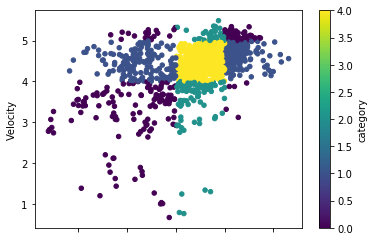

In [29]:
df.plot(x='Vol_mean', y='Velocity', kind = 'scatter', c ='category', colormap='viridis')

In [30]:
df_good = df.loc[df['category'] == 4, :]

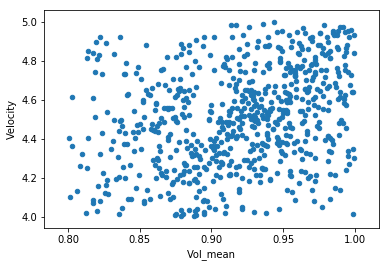

In [31]:
df_good.plot(x='Vol_mean', y='Velocity', kind = 'scatter')

In [14]:
len(df_good)

678

In [32]:
df_good.to_csv("%s/full_results_within_range.csv" % (result_root))